<a href="https://colab.research.google.com/github/NHpanda/sdl.HelloAndroid/blob/master/portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<!-- JPN -->
# ゲームの売り上げ

<!-- JPN -->
ゲームの売り上げについて様々な手法を用いて回帰分析を行います。
これを様々なエンコーディング手法を用いて行うことで最適な回帰分析の手法やエンコーディングの種類を決定します。

**1 | データの整理と回帰分析を行う関数の定義**

**2 | One-Hotエンコーディング**

**3 | カウントエンコーディング**

**4 | ラベルエンコーディング**

**5 | 考察**

<!-- JPN -->
## 1 | データの整理と回帰分析を行う関数の定義

<!-- JPN -->
### 1.1 | データの整理

<!-- JPN -->
まずは pandas を利用して、データセットを読み込みます。このデータセットにはいくつかのゲームについて以下のような情報がまとめられています。

|  変数  | 説明  |
| ---- | ---- |
|Rank | 全世界での売り上げランキング|
|Name | ゲームの名前 |
|Platform | リリースされたゲームのプラットフォーム|
|Year | 発売された年|
|Genre | ゲームのジャンル|
|Publisher| ゲームを発売した会社|
|NA_Sales | 北アメリアにおける売り上げ(/百万円)|
|EU_Sales | ヨーロッパにおける売り上げ(/百万円)|
|JP_Sales | 日本における売り上げ(/百万円)|
|Other_Sales | その他の売り上げ(/百万円)|
|Global_Sales | 全世界での売り上げ(/百万円)|

In [ ]:
import numpy as np
import pandas as pd
df = pd.read_csv("vgsales.csv")
print(df.head())

   Rank                      Name Platform    Year         Genre Publisher  \
0     1                Wii Sports      Wii  2006.0        Sports  Nintendo   
1     2         Super Mario Bros.      NES  1985.0      Platform  Nintendo   
2     3            Mario Kart Wii      Wii  2008.0        Racing  Nintendo   
3     4         Wii Sports Resort      Wii  2009.0        Sports  Nintendo   
4     5  Pokemon Red/Pokemon Blue       GB  1996.0  Role-Playing  Nintendo   

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales  
0     41.49     29.02      3.77         8.46         82.74  
1     29.08      3.58      6.81         0.77         40.24  
2     15.85     12.88      3.79         3.31         35.82  
3     15.75     11.01      3.28         2.96         33.00  
4     11.27      8.89     10.22         1.00         31.37  


<!-- JPN -->
今回は"Platform","Year","Genre","Publisher"からそれぞれの売り上げを回帰することを考えます。

In [ ]:
df = df[["Platform", "Year", "Genre", "Publisher", "NA_Sales", "EU_Sales", "JP_Sales", "Global_Sales"]]

--------

<!-- JPN -->
### 1.2 | 回帰分析を行う関数の定義

今回はランダムフォレスト、アダブースト、リッジ回帰、ニューラルネットワークの4種類の手法を用います。

<!-- JPN -->
まずはランダムフォレストです。今回は交差検証法を用いて、ランダムフォレストに対する適切なハイパーパラメータを決定し、そのパラメータを用いてもう一度ランダムフォレストで学習します。評価指標はMAEとし、探索するハイパーパラメータは以下の通りとします。

|  変数  | パラメータの範囲  |
| ---- | ---- |
|  `n_estimators` | `10, 20`  |
|  `max_depth`  | `2, 4, 6` |

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

def RandomForest(X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2, random_state=0)

  rfr = RandomForestRegressor(random_state=0)
  param_grid = [  
  {
      "n_estimators" : [10,20]
      , "max_depth": [2,4,6]
  }
  ]
  grid_search_dt = GridSearchCV(rfr, param_grid, cv=5, scoring="neg_mean_absolute_error")
  grid_search_dt.fit(X_train, Y_train)
  BP = grid_search_dt.best_params_

  rfr2 = RandomForestRegressor(max_depth = BP['max_depth'], n_estimators = BP['n_estimators'], random_state=0)
  rfr2.fit(X_train, Y_train)

  predicted = rfr2.predict(X_test)
  mae_sklearn_val  = mean_absolute_error(Y_test, predicted)
  print(f"rfrmae: {mae_sklearn_val:.3f}")

  # fti = rfr2.feature_importances_
  # labels = X.columns
  # plt.figure(figsize = (10,6))
  # plt.barh(y = range(len(fti)), width = fti)
  # plt.yticks(ticks = range(len(labels)), labels = labels)
  # plt.show()

<!-- JPN -->
次にアダブーストです。今回は交差検証法を用いて、アダブーストで使用する決定木に対する適切なハイパーパラメータを決定します。そして求めたパラメータを用いた新しい決定木を使用してアダブーストで学習します。評価指標はMAEとし、探索するハイパーパラメータは以下の通りとします。

|  変数  | パラメータの範囲  |
| ---- | ---- |
|  `max_depth` | `2, 4, 6, 8, 10`  |

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

def AdaBoost(X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2, random_state=0)

  ab = AdaBoostRegressor(n_estimators = 10, random_state = 0)
  param_grid = [  
  {
      "base_estimator": [DecisionTreeRegressor(max_depth = i, random_state=0) for i in range(2, 10, 2)]
  }
  ]
  grid_search_dt = GridSearchCV(ab, param_grid, cv=5, scoring="neg_mean_absolute_error")
  grid_search_dt.fit(X_train, Y_train)
  BP2 = grid_search_dt.best_params_

  ab2 = AdaBoostRegressor(random_state=0, n_estimators = 10, base_estimator = BP2['base_estimator'])
  ab2.fit(X_train, Y_train)

  predicted = ab2.predict(X_test)
  mae_sklearn_val  = mean_absolute_error(Y_test, predicted)
  print(f"abmae: {mae_sklearn_val:.3f}")

<!-- JPN -->
次にリッジ回帰です。今回は交差検証法を用いて、多項式リッジ回帰予測モデルに対する適切なハイパーパラメータを決定し、そのパラメータを用いて新しい多項式リッジ回帰予測モデルを学習します。評価指標はMAEとし、探索するハイパーパラメータは以下の通りとします。

|  変数  | パラメータの範囲  |
| ---- | ---- |
|  次元数 `p` | `1, 2,`  |
|  正則化項の重み `alpha`  | `0.01, 0.1, 1, 10` |

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

def RidgeRegression(X, Y):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2, random_state=0)

  for p in range(1, 2):
    X_train_poly = PolynomialFeatures(degree=p, include_bias=False).fit_transform(X_train)
    ss = StandardScaler()
    X_train_poly_std = ss.fit_transform(X_train_poly)
    r = Ridge()
    param_grid = [  
    {
        "alpha": [0.01, 0.1, 1, 10]
    }
    ]
    grid_search_dt = GridSearchCV(r, param_grid, cv=5, scoring="neg_mean_absolute_error")
    grid_search_dt.fit(X_train_poly_std, Y_train)

    if p == 1:
      BS = grid_search_dt.best_score_
      BP = grid_search_dt.best_params_
      n = p

    if grid_search_dt.best_score_ < BS:
      BS = grid_search_dt.best_score_
      BP = grid_search_dt.best_params_
      n = p

  model_poly_ridge2 = make_pipeline(
      PolynomialFeatures(degree = n, include_bias = False),
      StandardScaler(),
      Ridge(alpha = BP['alpha']))
  model_poly_ridge2.fit(X_train, Y_train)

  predicted = model_poly_ridge2.predict(X_test)
  mae_sklearn_val = mean_absolute_error(Y_test, predicted)
  print(f"rrmae: {mae_sklearn_val:.3f}")

<!-- JPN -->
最後にニューラルネットワークです。回帰予測を行う際に以下の様に設定しました。

- ニューラルネットワークに入力する特徴量はあらかじめ標準化（あるいは正規化）しておく（これは分類予測でも同様である）。
- 入力特徴量、出力特徴量共に `torch.float` にしておく。
- 使用するモデルは多層パーセプトロンとする。
- 1つの値を予測したいので、出力は1次元とする。
- 損失関数を `torch.nn.L1Loss` にする。
- 確率的勾配降下法 (stochastic gradient descent; SGD)をoptimizerとする。
- 勾配消失を起こさないために活性化関数にReLU関数とする。
- 過学習を抑える正則化の方法としてDropoutを用いる。

ここでは、モデル `model` 、損失関数 `loss_fn`、および最適化手法 `opt` を引数とすることで、汎用的に学習や予測を行えるコードを作成してみました。

In [ ]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def calculate(model, loss_fn, loader, opt=None):
  if opt is None:
    model.eval()

  whole_loss = 0
  count = len(loader.dataset)
  
  for X, y in loader:
    X, y = X.cuda(), y.cuda() # Transfer data to the GPU
    y_pred = model(X) # Predict y from X 
    
    loss = loss_fn(y_pred, y)  # Calculate the average of the losses in a mini-batch
    whole_loss += loss.item()*len(y) # Calculate the total loss for the entire epoch
    
    # Update weights
    if opt is not None:
      opt.zero_grad()
      loss.backward()
      opt.step()
    
  mean_loss = whole_loss / count

  if opt is None:
    model.train()

  return mean_loss

In [ ]:
from livelossplot import PlotLosses
def train(model, loss_fn, opt, train_loader, valid_loader, epoch=50):
  liveloss = PlotLosses() # Initialize the drawing
  for i in range(epoch):
    train_loss = calculate(model, loss_fn, train_loader, opt)
    valid_loss = calculate(model, loss_fn, valid_loader)
  
    # Visualize the loss and accuracy values.
    liveloss.update({
        'loss': train_loss,
        'val_loss': valid_loss,
    })
    liveloss.draw()  
  return model # Return the trained model

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import numpy as np

def NeuralNetwork(X, Y, d):
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    test_size=0.2, random_state=0)
  X_train_sub, X_valid, Y_train_sub, Y_valid = train_test_split(X_train, Y_train,
                                                    test_size=0.2, random_state=0)
  Y_train_sub = Y_train_sub.to_numpy()
  Y_valid = Y_valid.to_numpy()
  Y_test = Y_test.to_numpy()

  ss = StandardScaler()
  X_train_sub_std = ss.fit_transform(X_train_sub)
  X_valid_std     = ss.transform(X_valid)
  X_test_std     = ss.transform(X_test)

  batch_size = 32

  X_train_torch = torch.tensor(X_train_sub_std, dtype=torch.float)
  X_valid_torch = torch.tensor(X_valid_std, dtype=torch.float)
  X_test_torch = torch.tensor(X_test_std, dtype=torch.float)

  Y_train_torch = torch.tensor(Y_train_sub.reshape(-1, 1), dtype=torch.float)
  Y_valid_torch = torch.tensor(Y_valid.reshape(-1,1), dtype=torch.float)
  Y_test_torch = torch.tensor(Y_test.reshape(-1,1), dtype=torch.float)

  train_dataset = torch.utils.data.TensorDataset(X_train_torch, Y_train_torch)
  valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, Y_valid_torch)
  test_dataset = torch.utils.data.TensorDataset(X_test_torch, Y_test_torch)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

  torch.manual_seed(0)
  torch.backends.cudnn.deterministic = True

  mlp = torch.nn.Sequential(
    torch.nn.Linear(len(X.columns), d),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(d, 1)
  )
  mlp.cuda()

  loss_fn = torch.nn.L1Loss()
  optimizer = torch.optim.SGD(mlp.parameters(), lr=0.01)

  trained_model = train(mlp, loss_fn, optimizer, train_loader, valid_loader, epoch=100)

  test_loss = calculate(trained_model, loss_fn, test_loader)
  print(f"nnmae: {test_loss:.3f}")

<!-- JPN -->
## 2 | One-Hotエンコーディング

OneーHotエンコーディングとは、対象のカテゴリー変数の構成要素分の変数を作成し、作り出した各変数は行単位で「該当なし:0、該当あり:1」を変換する手法です。

<!-- JPN -->
データに存在する"Platform"、"Publisher"、"Genre"に対してOne-Hotエンコーディングを施し、それぞれの回帰分析手法を適用し、最適な手法を決定します。

In [ ]:
df_oh = pd.get_dummies(df)
print(df_oh.columns)

Index(['Year', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Global_Sales',
       'Platform_2600', 'Platform_3DO', 'Platform_3DS', 'Platform_DC',
       'Platform_DS',
       ...
       'Publisher_Zushi Games', 'Publisher_bitComposer Games',
       'Publisher_dramatic create', 'Publisher_fonfun', 'Publisher_iWin',
       'Publisher_id Software', 'Publisher_imageepoch Inc.',
       'Publisher_inXile Entertainment', 'Publisher_mixi, Inc',
       'Publisher_responDESIGN'],
      dtype='object', length=626)


In [ ]:
print(df_oh.describe().loc["count"])

Year                              16327.0
NA_Sales                          16598.0
EU_Sales                          16598.0
JP_Sales                          16598.0
Global_Sales                      16598.0
                                   ...   
Publisher_id Software             16598.0
Publisher_imageepoch Inc.         16598.0
Publisher_inXile Entertainment    16598.0
Publisher_mixi, Inc               16598.0
Publisher_responDESIGN            16598.0
Name: count, Length: 626, dtype: float64


In [ ]:
A1 = df_oh.describe().loc["count"] != 16598.0
print(A1[A1 == True])

Year    True
Name: count, dtype: bool


In [ ]:
df_oh = df_oh.dropna()

In [ ]:
print(df_oh.describe().loc["count"])

Year                              16327.0
NA_Sales                          16327.0
EU_Sales                          16327.0
JP_Sales                          16327.0
Global_Sales                      16327.0
                                   ...   
Publisher_id Software             16327.0
Publisher_imageepoch Inc.         16327.0
Publisher_inXile Entertainment    16327.0
Publisher_mixi, Inc               16327.0
Publisher_responDESIGN            16327.0
Name: count, Length: 626, dtype: float64


In [ ]:
A2 = df_oh.describe().loc["count"] != 16327.0
print(A2[A2 == True])

Series([], Name: count, dtype: bool)


In [ ]:
Y1 = df_oh["NA_Sales"]
Y2 = df_oh["EU_Sales"]
Y3 = df_oh["JP_Sales"]
Y4 = df_oh["Global_Sales"]

df_oh2 = df_oh.drop("NA_Sales", axis = 1)
df_oh3 = df_oh2.drop("EU_Sales", axis = 1)
df_oh4 = df_oh3.drop("JP_Sales", axis = 1)
X = df_oh4.drop("Global_Sales", axis = 1)

<!-- JPN -->
One-Hotエンコーディングを適用し、欠損値の存在する行を削除したので早速回帰分析を行います。

In [ ]:
RandomForest(X, Y4)

rfrmae: 0.518


In [ ]:
AdaBoost(X, Y4)

abmae: 0.540


In [ ]:
RidgeRegression(X, Y4)

rrmae: 0.536


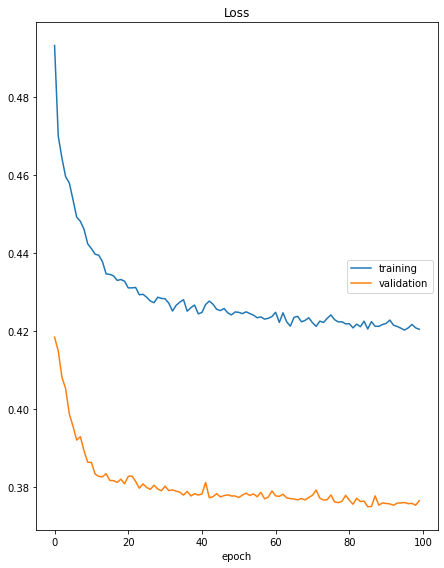

Loss
	training         	 (min:    0.420, max:    0.493, cur:    0.420)
	validation       	 (min:    0.375, max:    0.418, cur:    0.376)
nnmae: 0.417


In [ ]:
NeuralNetwork(X, Y4, 50)

<!-- JPN -->
## 3 | カウントエンコーディング

カウント（Frequency）エンコーディングとは、特徴量の各値の出現頻度で置き換える手法です。エンコーディング後の値の大小（出現頻度）に意味が発生します。

<!-- JPN -->
データに存在する"Platform"、"Publisher"、"Genre"に対してカウントエンコーディングを施し、それぞれの回帰分析手法を適用し、最適な手法を決定します。

In [ ]:
df_c = df.copy()
count_Platform = df_c['Platform'].value_counts().to_dict()
print(count_Platform)
df_c['Platform_count'] = df_c['Platform'].map(count_Platform)
print(df_c.head())

{'DS': 2163, 'PS2': 2161, 'PS3': 1329, 'Wii': 1325, 'X360': 1265, 'PSP': 1213, 'PS': 1196, 'PC': 960, 'XB': 824, 'GBA': 822, 'GC': 556, '3DS': 509, 'PSV': 413, 'PS4': 336, 'N64': 319, 'SNES': 239, 'XOne': 213, 'SAT': 173, 'WiiU': 143, '2600': 133, 'NES': 98, 'GB': 98, 'DC': 52, 'GEN': 27, 'NG': 12, 'SCD': 6, 'WS': 6, '3DO': 3, 'TG16': 2, 'GG': 1, 'PCFX': 1}
  Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77   
1      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81   
2      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79   
3      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28   
4       GB  1996.0  Role-Playing  Nintendo     11.27      8.89     10.22   

   Global_Sales  Platform_count  
0         82.74            1325  
1         40.24              98  
2         35.82            1325  
3         33.00            1325  
4         31.

In [ ]:
count_Publisher = df_c['Publisher'].value_counts().to_dict()
print(count_Publisher)
df_c['Publisher_count'] = df_c['Publisher'].map(count_Publisher)
print(df_c.head())

{'Electronic Arts': 1351, 'Activision': 975, 'Namco Bandai Games': 932, 'Ubisoft': 921, 'Konami Digital Entertainment': 832, 'THQ': 715, 'Nintendo': 703, 'Sony Computer Entertainment': 683, 'Sega': 639, 'Take-Two Interactive': 413, 'Capcom': 381, 'Atari': 363, 'Tecmo Koei': 338, 'Square Enix': 233, 'Warner Bros. Interactive Entertainment': 232, 'Disney Interactive Studios': 218, 'Unknown': 203, 'Midway Games': 198, 'Eidos Interactive': 198, '505 Games': 192, 'Microsoft Game Studios': 189, 'D3Publisher': 184, 'Acclaim Entertainment': 184, 'Vivendi Games': 164, 'Codemasters': 152, 'Idea Factory': 129, 'Deep Silver': 122, 'Nippon Ichi Software': 105, 'Zoo Digital Publishing': 104, 'Majesco Entertainment': 92, 'LucasArts': 90, 'Rising Star Games': 86, 'Hudson Soft': 81, 'Banpresto': 73, 'Bethesda Softworks': 71, 'Crave Entertainment': 71, 'Atlus': 67, 'Virgin Interactive': 62, 'Infogrames': 62, 'Ignition Entertainment': 61, '5pb': 61, 'Focus Home Interactive': 58, 'Marvelous Interactive': 

In [ ]:
count_Genre = df_c['Genre'].value_counts().to_dict()
print(count_Genre)
df_c['Genre_count'] = df_c['Genre'].map(count_Genre)
print(df_c.head())

{'Action': 3316, 'Sports': 2346, 'Misc': 1739, 'Role-Playing': 1488, 'Shooter': 1310, 'Adventure': 1286, 'Racing': 1249, 'Platform': 886, 'Simulation': 867, 'Fighting': 848, 'Strategy': 681, 'Puzzle': 582}
  Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77   
1      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81   
2      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79   
3      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28   
4       GB  1996.0  Role-Playing  Nintendo     11.27      8.89     10.22   

   Global_Sales  Platform_count  Publisher_count  Genre_count  
0         82.74            1325            703.0         2346  
1         40.24              98            703.0          886  
2         35.82            1325            703.0         1249  
3         33.00            1325            703.0         2346  
4         31.37  

In [ ]:
print(df_c.describe().loc["count"])

Year               16327.0
NA_Sales           16598.0
EU_Sales           16598.0
JP_Sales           16598.0
Global_Sales       16598.0
Platform_count     16598.0
Publisher_count    16540.0
Genre_count        16598.0
Name: count, dtype: float64


In [ ]:
B1 = df_c.describe().loc["count"] != 16598.0
print(B1[B1 == True])

Year               True
Publisher_count    True
Name: count, dtype: bool


In [ ]:
df_c = df_c.dropna()

In [ ]:
print(df_c.describe().loc["count"])

Year               16291.0
NA_Sales           16291.0
EU_Sales           16291.0
JP_Sales           16291.0
Global_Sales       16291.0
Platform_count     16291.0
Publisher_count    16291.0
Genre_count        16291.0
Name: count, dtype: float64


In [ ]:
B2 = df_c.describe().loc["count"] != 16291.0
print(B2[B2 == True])

Series([], Name: count, dtype: bool)


In [ ]:
Y1 = df_c["NA_Sales"]
Y2 = df_c["EU_Sales"]
Y3 = df_c["JP_Sales"]
Y4 = df_c["Global_Sales"]
X = df_c[["Year", "Platform_count", "Publisher_count", "Genre_count"]]

<!-- JPN -->
カウントエンコーディングを適用し、欠損値の存在する行を削除したので早速回帰分析を行います。

In [ ]:
RandomForest(X, Y4)

rfrmae: 0.526


In [ ]:
AdaBoost(X, Y4)

abmae: 0.568


In [ ]:
RidgeRegression(X, Y4)

rrmae: 0.579


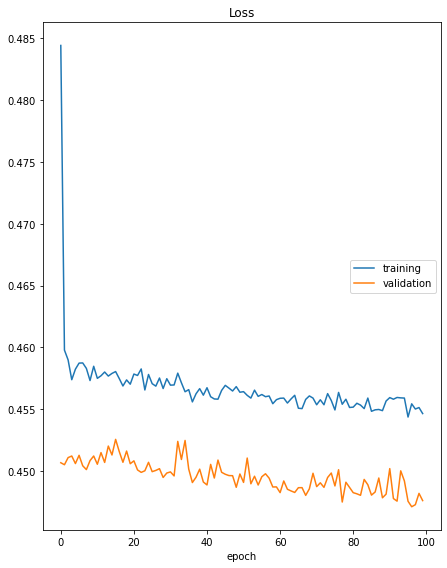

Loss
	training         	 (min:    0.454, max:    0.484, cur:    0.455)
	validation       	 (min:    0.447, max:    0.453, cur:    0.448)
nnmae: 0.449


In [ ]:
NeuralNetwork(X, Y4, 50)

<!-- JPN -->
## 4 | ラベルエンコーディング

ラベル・エンコーディングとは、ラベルの種類に応じた数値を割り当てて特徴量を生成する手法です。

<!-- JPN -->
データに存在する"Platform"、"Publisher"、"Genre"に対してラベルエンコーディングを施し、それぞれの回帰分析手法を適用し、最適な手法を決定します。今回はそれぞれに対する"Global_Sales"の合計に従ってラベルを定めました。

In [ ]:
df_l = df.copy()
sales_Platform = {}
for i in range(len(df["Platform"].unique())):
  Pl_name = df["Platform"].unique()[i]
  sales_Platform[Pl_name] = df[df["Platform"] == Pl_name]["Global_Sales"].sum()
print(sales_Platform)
df_l['Platform_sales'] = df_l['Platform'].map(sales_Platform)
print(df_l.head())

{'Wii': 926.71, 'NES': 251.07, 'GB': 255.45000000000002, 'DS': 822.49, 'X360': 979.96, 'PS3': 957.84, 'PS2': 1255.6399999999999, 'SNES': 200.05, 'GBA': 318.5, '3DS': 247.46, 'PS4': 278.1, 'N64': 218.88, 'PS': 730.66, 'XB': 258.26, 'PC': 258.82, '2600': 97.07999999999998, 'PSP': 296.28000000000003, 'XOne': 141.06, 'GC': 199.35999999999999, 'WiiU': 81.86000000000001, 'GEN': 28.36, 'DC': 15.969999999999999, 'PSV': 61.930000000000014, 'SAT': 33.59, 'SCD': 1.8700000000000003, 'WS': 1.42, 'NG': 1.4400000000000002, 'TG16': 0.16, '3DO': 0.1, 'GG': 0.04, 'PCFX': 0.03}
  Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77   
1      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81   
2      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79   
3      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28   
4       GB  1996.0  Role-Playing  Nintendo     11.27  

In [ ]:
sales_Publisher = {}
for i in range(len(df["Publisher"].unique())):
  Pu_name = df["Publisher"].unique()[i]
  sales_Publisher[Pu_name] = df[df["Publisher"] == Pu_name]["Global_Sales"].sum()
print(sales_Publisher)
df_l['Publisher_sales'] = df_l['Publisher'].map(sales_Publisher)
print(df_l.head())

{'Nintendo': 1786.5600000000002, 'Microsoft Game Studios': 245.79000000000002, 'Take-Two Interactive': 399.53999999999996, 'Sony Computer Entertainment': 607.5000000000001, 'Activision': 727.46, 'Ubisoft': 474.72, 'Bethesda Softworks': 82.14, 'Electronic Arts': 1110.3200000000002, 'Sega': 272.98999999999995, 'SquareSoft': 57.650000000000006, 'Atari': 157.22, '505 Games': 55.910000000000004, 'Capcom': 200.89000000000004, 'GT Interactive': 25.23, 'Konami Digital Entertainment': 283.64, 'Sony Computer Entertainment Europe': 23.890000000000004, 'Square Enix': 145.18, 'LucasArts': 87.34, 'Virgin Interactive': 43.87000000000001, 'Warner Bros. Interactive Entertainment': 153.89, 'Universal Interactive': 17.770000000000003, 'Eidos Interactive': 98.98, 'RedOctane': 8.68, 'Vivendi Games': 58.21, 'Enix Corporation': 33.739999999999995, 'Namco Bandai Games': 254.09, 'Palcom': 4.17, 'Hasbro Interactive': 15.22, 'THQ': 340.77, 'Fox Interactive': 7.389999999999999, 'Acclaim Entertainment': 64.14, 'MT

In [ ]:
sales_Genre = {}
for i in range(len(df["Genre"].unique())):
  G_name = df["Genre"].unique()[i]
  sales_Genre[G_name] = df[df["Genre"] == G_name]["Global_Sales"].sum()
print(sales_Genre)
df_l['Genre_sales'] = df_l['Genre'].map(sales_Genre)
print(df_l.head())

{'Sports': 1330.93, 'Platform': 831.37, 'Racing': 732.04, 'Role-Playing': 927.37, 'Puzzle': 244.95, 'Misc': 809.9600000000002, 'Shooter': 1037.3700000000001, 'Simulation': 392.2000000000001, 'Action': 1751.18, 'Fighting': 448.91, 'Adventure': 239.03999999999996, 'Strategy': 175.12000000000003}
  Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77   
1      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81   
2      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79   
3      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28   
4       GB  1996.0  Role-Playing  Nintendo     11.27      8.89     10.22   

   Global_Sales  Platform_sales  Publisher_sales  Genre_sales  
0         82.74          926.71          1786.56      1330.93  
1         40.24          251.07          1786.56       831.37  
2         35.82          926.71          1786.56       7

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le = le.fit(df_l['Platform_sales'])
df_l['Platform_sales'] = le.transform(df_l['Platform_sales'])

le = le.fit(df_l['Publisher_sales'])
df_l['Publisher_sales'] = le.transform(df_l['Publisher_sales'])

le = le.fit(df_l['Genre_sales'])
df_l['Genre_sales'] = le.transform(df_l['Genre_sales'])

print(df_l.head())

  Platform    Year         Genre Publisher  NA_Sales  EU_Sales  JP_Sales  \
0      Wii  2006.0        Sports  Nintendo     41.49     29.02      3.77   
1      NES  1985.0      Platform  Nintendo     29.08      3.58      6.81   
2      Wii  2008.0        Racing  Nintendo     15.85     12.88      3.79   
3      Wii  2009.0        Sports  Nintendo     15.75     11.01      3.28   
4       GB  1996.0  Role-Playing  Nintendo     11.27      8.89     10.22   

   Global_Sales  Platform_sales  Publisher_sales  Genre_sales  
0         82.74              27              290           10  
1         40.24              18              290            7  
2         35.82              27              290            5  
3         33.00              27              290           10  
4         31.37              19              290            8  


In [ ]:
print(df_l.describe().loc["count"])

Year               16327.0
NA_Sales           16598.0
EU_Sales           16598.0
JP_Sales           16598.0
Global_Sales       16598.0
Platform_sales     16598.0
Publisher_sales    16598.0
Genre_sales        16598.0
Name: count, dtype: float64


In [ ]:
C1 = df_l.describe().loc["count"] != 16598.0
print(C1[C1 == True])

Year    True
Name: count, dtype: bool


In [ ]:
df_l = df_l.dropna()

In [ ]:
print(df_l.describe().loc["count"])

Year               16291.0
NA_Sales           16291.0
EU_Sales           16291.0
JP_Sales           16291.0
Global_Sales       16291.0
Platform_sales     16291.0
Publisher_sales    16291.0
Genre_sales        16291.0
Name: count, dtype: float64


In [ ]:
C2 = df_l.describe().loc["count"] != 16291.0
print(C2[C2 == True])

Series([], Name: count, dtype: bool)


In [ ]:
Y1 = df_l["NA_Sales"]
Y2 = df_l["EU_Sales"]
Y3 = df_l["JP_Sales"]
Y4 = df_l["Global_Sales"]
X = df_l[["Year", "Platform_sales", "Publisher_sales", "Genre_sales"]]

<!-- JPN -->
ラベルエンコーディングを適用し、欠損値の存在する行を削除したので早速回帰分析を行います。

In [ ]:
RandomForest(X, Y4)

rfrmae: 0.521


In [ ]:
AdaBoost(X, Y4)

abmae: 0.567


In [ ]:
RidgeRegression(X, Y4)

rrmae: 0.587


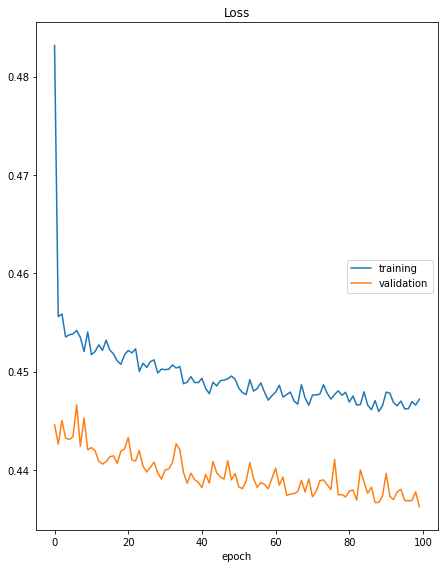

Loss
	training         	 (min:    0.446, max:    0.483, cur:    0.447)
	validation       	 (min:    0.436, max:    0.447, cur:    0.436)
nnmae: 0.441


In [ ]:
NeuralNetwork(X, Y4, 50)

<!-- JPN -->
## 5 | 考察

<!-- JPN -->
### 5.1 | エンコーディング手法ごとの回帰手法の比較

<!-- JPN -->
まずはそれぞれのエンコーディングごとに回帰手法の性能を比較するためMAEの小さい順に並べてみます。

- One-Hotエンコーディング

ニューラルネットワーク　<　ランダムフォレスト　<　多項式リッジ回帰　<　アダブースト

- カウントエンコーディング

ニューラルネットワーク　<　ランダムフォレスト　<　アダブースト　<　多項式リッジ回帰

- ラベルエンコーディング

ニューラルネットワーク　<　ランダムフォレスト　<　アダブースト　<　多項式リッジ回帰

<!-- JPN -->
上記の結果からどのエンコーディングにおいてもニューラルネットワークが一番性能が良くなることがわかります。この結果からニューラルネットワーク以外の手法ではハイパーパラメータを探索した際に適切なハイパーパラメータを見つけることができていない可能性があることがわかります。今後取り組む際にはハイパーパラメータの候補を増やして十分な探索を行いたいです。

<!-- JPN -->
### 5.2 | 回帰手法ごとのエンコーディング手法の比較

<!-- JPN -->
次にそれぞれの回帰手法ごとにエンコーディング手法を比較するためMAEの小さい順に並べてみる。

- ランダムフォレスト

One-Hot　<　ラベル　<　カウント

- アダブースト

One-Hot　<　ラベル　<　カウント

- 多項式リッジ回帰

One-Hot　<　カウント　<　ラベル

- ニューラルネットワーク

One-Hot　<　ラベル　<　カウント

<!-- JPN -->
上記の結果からどの回帰手法においてもOne-Hotエンコーディングが一番性能が良くなることがわかります。これはカウントエンコーディングやラベルエンコーディングではラベル間の数値の大小関係を学んでしまい、発生頻度は低いが重要な変数などを学習しづらく、またエンコーディングの際、無意味な順序付けが発生してしまうことが影響していると考えられます。さらにカウントエンコーディングでは異なるカテゴリカル変数に同じ値が割り当てられ、情報が失われる場合があるため、このことも影響し、ほとんどの場合で性能が一番性能が悪くなっていると考えられます。

<!-- JPN -->
### 5.3 | まとめ

<!-- JPN -->
今後の取り組みとして以下のことを改善したいと思います。

- ランダムフォレスト、アダブースト、多項式リッジ回帰のハイパーパラメータの探索範囲を拡大する。
- ニューラルネットワークのバッチサイズやエポック数、層の数について今回は故意に選んだためより適切な値を定める。
- 今回はOne-Hotエンコーディングが一番性能が良かったが今回扱ったデータのようにカテゴリ数が非常に多いデータセットに対してOne-Hotエンコーディングをすると、ランダムフォレストなどランダムに特徴量を選択するアルゴリズムでは、数値変数などの非カテゴリカル変数の選択率が減少して精度が落ちる場合があるため新しいエンコーディング手法を検討する。